# Thai, CC100, XNLI


In [40]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

from utils import human_format, percentage, invert_human_format
tab_colors = list(mcolors.TABLEAU_COLORS.keys())

In [41]:
res = pd.read_csv('./results/cc100/res_thai_ablation_token_number.csv')

In [42]:
lang_tag_list = ['ar', 'bg', 'de', 'el', 'es', 'fr',
                   'hi', 'ru', 'sw', 'th', 'tr', 'ur',
                   'vi', 'zh']
def obtain_tag_lang(tags):
    """
    Returns the first tag in the list of tags (separated by commas) that matches an element in tag_list.
    If no match is found, returns None.
    """
    tags = tags.strip().split(',')
    for tag in tags:
        tag = tag.strip()
        if tag in lang_tag_list:
            return tag
        

def obtain_model_dir(save_dir):
    """
    Returns the part of the save directory after "exps/".
    """
    return save_dir.split('exps/')[-1]


def obtain_tag_model_type(tags):
    """ 
    Returns the first tag that matches either "standard" or "forget". 
    If no match is found, the function returns None
    """
    tags = tags.strip().split(',')
    for tag in tags:
        tag = tag.strip()
        if tag in ['standard', 'forget']:
            return tag    


def obtain_data_size(data_dir):
    """
    Returns the size of the data.
    If the data directory contains "-fixed-valid-", 
    returns the last element after splitting the string by dash as a float.
    Otherwise, returns 1.0.
    """
    # print(data_dir)
    if '-fixed-valid-' in data_dir:
        return float(invert_human_format(data_dir.split('-')[-1]))
    else:
        return 1.0

res['lang'] = res['Tags'].apply(obtain_tag_lang)
res['model_type'] = res['Tags'].apply(obtain_tag_model_type)
res['model_dir'] = res['args.save_dir'].apply(obtain_model_dir)
res['data_size'] = res['args.data'].apply(obtain_data_size)

In [47]:
coarse = True # !!!!!!!!!
# filter specific run
# res = res[(res['data_size'] == 0.01) | (res['data_size'] == 0.1)]
# res = res[res['model_type'] == 'forget']
# res = res[res['lang'] == 'ar']

cmd_template = """
export NLI_IRoberta="{}"
export ADAPT_IRoberta="{}"

EMB="${EXP_DIR}${ADAPT_IRoberta}"
BODY="${EXP_DIR}${NLI_IRoberta}"
SPLICE="${EXP_DIR}splice/nli/{}/"
python fb_sweep/splice_emb_body.py --emb_path $EMB --body_path $BODY --splice_path $SPLICE
"""
MAX_UPDATES = 5000
MIN_UPDATES = 0
NLI_BODY_PATH = {'standard':'cc100/nli-roberta-base/NLI.fp16.sentpred.bos0.sep2.froberta_base.adam.b2_0.98.eps1e-06.clip0.0.lr1e-05.mu122720.dr0.1.atdr0.1.wd0.01.ms32.uf1.s1.ngpu1/checkpoint_best.pt', 
                 'forget':'cc100/nli-clip0.5.adamef.k1000/NLI.fp16.sentpred.bos0.sep2.firoberta_base.adam.b2_0.98.eps1e-06.clip0.0.lr1e-05.mu122720.dr0.1.atdr0.1.wd0.01.ms32.uf1.s1.ngpu1/checkpoint_best.pt'}
model_type_list = []
data_size_list = []
num_update_list = []
alias_list = []
lang_list = []
for i,row in res.iterrows():
    lang = row['lang']
    model_dir = row['model_dir']
    model_type = row['model_type']
    data_size = row['data_size']
    files = os.listdir(row['args.save_dir'])
    # files = [f for f in files if ('_' in f) and ('best' not in f) and ('last' not in f)]
    files = [f for f in files if ('best' in f)]
    # print(files)
    for file in files:
        num_updates = file.split('_')[-1].split('.')[0]
        # if coarse == True:
        #     cond = int(num_updates) % 125000 == 0 # and int(num_updates) > 80000
        # else:
        #     cond = int(num_updates) <= MAX_UPDATES and int(num_updates) > MIN_UPDATES
        cond = True
        if cond == True:
            emb_path = model_dir + '/' + file
            body_path = NLI_BODY_PATH[model_type]
            splice_path = '{}_adapt-emb-{}{}-step{}_finetune-body-en'.format(model_type, lang, data_size, num_updates)
            # print(emb_path, splice_path)
            cmd = cmd_template.format(body_path, emb_path, splice_path, 
                                      EXP_DIR='{EXP_DIR}', 
                                      ADAPT_IRoberta='{ADAPT_IRoberta}', 
                                      NLI_IRoberta='{NLI_IRoberta}')
            print('#{}'.format(splice_path))
            print(cmd)
            num_update_list.append(num_updates)
            data_size_list.append(data_size)
            model_type_list.append(model_type)
            alias_list.append(splice_path)
            lang_list.append(lang)

#standard_adapt-emb-th5000000.0-stepbest_finetune-body-en

export NLI_IRoberta="cc100/nli-roberta-base/NLI.fp16.sentpred.bos0.sep2.froberta_base.adam.b2_0.98.eps1e-06.clip0.0.lr1e-05.mu122720.dr0.1.atdr0.1.wd0.01.ms32.uf1.s1.ngpu1/checkpoint_best.pt"
export ADAPT_IRoberta="cc100/adapt20230806-110219/forgeT.firoberta_base.adam.lr0.0007.wu10000.ms32.uf2.mu125000.s1.ngpu32/checkpoint_best.pt"

EMB="${EXP_DIR}${ADAPT_IRoberta}"
BODY="${EXP_DIR}${NLI_IRoberta}"
SPLICE="${EXP_DIR}splice/nli/standard_adapt-emb-th5000000.0-stepbest_finetune-body-en/"
python fb_sweep/splice_emb_body.py --emb_path $EMB --body_path $BODY --splice_path $SPLICE

#forget_adapt-emb-th5000000.0-stepbest_finetune-body-en

export NLI_IRoberta="cc100/nli-clip0.5.adamef.k1000/NLI.fp16.sentpred.bos0.sep2.firoberta_base.adam.b2_0.98.eps1e-06.clip0.0.lr1e-05.mu122720.dr0.1.atdr0.1.wd0.01.ms32.uf1.s1.ngpu1/checkpoint_best.pt"
export ADAPT_IRoberta="cc100/adapt20230808-091906/forgeT.firoberta_base.adam.lr0.0007.wu10000.ms32.uf

In [48]:
df = pd.DataFrame({'model_type': model_type_list, 'data_size': data_size_list, 
                   'num_update': num_update_list, 'alias': alias_list, 'lang': lang_list})
df = df.drop_duplicates()

In [49]:
dict_template = """
    "{}": {{
         "model_path": BASEDIR + "exps/splice/nli/{}/checkpoint_best.pt",
        "model_overrides": {{"bpe": "sentencepiece", "sentencepiece_model": {}_SPM}},
        "label_fn": LABEL_FN,
    }},"""


with open('../fb_sweep/model_list/NLI_thai_ablation.py', 'w') as f:
    print("""
LABEL_FN = lambda x: {0: 'contradiction', 1: 'neutral', 2: 'entailment'}[x]
BASEDIR = "/checkpoint/yhc/inductivise-lm/inductivise-lm/"
TH_SPM = BASEDIR + "datasets/cc100/th/spm/cc100.th.spm.model" 
""", file=f)
    print("MODELS = {", file=f)
    for i, row in df.iterrows():
        d = dict_template.format(row['alias'], row['alias'], row['lang'].upper())
        print(d, file=f)
    print("}", file=f)

In [50]:
eval_cmd_template = """echo {}
python fb_sweep/eval_xnli.py --langs {} --data $XNLI_DATA --model {} --choice thai_ablation
"""
    
for i, row in df.iterrows():
    eval_cmd = eval_cmd_template.format(row['alias'], row['lang'], row['alias'], choice)
    print(eval_cmd)

echo standard_adapt-emb-th5000000.0-stepbest_finetune-body-en
python fb_sweep/eval_xnli.py --langs th --data $XNLI_DATA --model standard_adapt-emb-th5000000.0-stepbest_finetune-body-en --choice thai_ablation

echo forget_adapt-emb-th5000000.0-stepbest_finetune-body-en
python fb_sweep/eval_xnli.py --langs th --data $XNLI_DATA --model forget_adapt-emb-th5000000.0-stepbest_finetune-body-en --choice thai_ablation

echo standard_adapt-emb-th5000000000.0-stepbest_finetune-body-en
python fb_sweep/eval_xnli.py --langs th --data $XNLI_DATA --model standard_adapt-emb-th5000000000.0-stepbest_finetune-body-en --choice thai_ablation

echo forget_adapt-emb-th5000000000.0-stepbest_finetune-body-en
python fb_sweep/eval_xnli.py --langs th --data $XNLI_DATA --model forget_adapt-emb-th5000000000.0-stepbest_finetune-body-en --choice thai_ablation

echo forget_adapt-emb-th1000000.0-stepbest_finetune-body-en
python fb_sweep/eval_xnli.py --langs th --data $XNLI_DATA --model forget_adapt-emb-th1000000.0-stepb

In [53]:
acc, alias = [], []
if coarse == True:
    log_path = 'launch_thai_ablation_best.out' #!!!!!!!!!!!!
else:
    log_path = '' #!!!!!!!!!!
    
with open(log_path, 'r') as f:
    for i,line in enumerate(f.readlines()):
        line = line.strip()
        if ('standard' in line or 'forget' in line) and ('checkpoint' not in line):
            # print(line)
            alias.append(line)
        if line[0].isdigit() == True and (',' not in line):
            # print(line)
            acc.append(float(line.split('\t')[0]))
#         if i%7 == 6:
#             print(i, len(acc), len(alias))
df_log = pd.DataFrame({'alias': alias, 'acc': acc})
df_final = pd.merge(df, df_log, on='alias')


In [54]:
df_final

,model_type,data_size,num_update,alias,lang,acc
0,standard,5.000000e+06,best,standard_adapt-emb-th5000000.0-stepbest_finetu...,th,33.5
1,forget,5.000000e+06,best,forget_adapt-emb-th5000000.0-stepbest_finetune...,th,57.4
2,standard,5.000000e+09,best,standard_adapt-emb-th5000000000.0-stepbest_fin...,th,67.6
3,forget,5.000000e+09,best,forget_adapt-emb-th5000000000.0-stepbest_finet...,th,61.0
4,forget,1.000000e+06,best,forget_adapt-emb-th1000000.0-stepbest_finetune...,th,36.1
5,standard,1.000000e+06,best,standard_adapt-emb-th1000000.0-stepbest_finetu...,th,35.2
6,standard,1.000000e+03,best,standard_adapt-emb-th1000.0-stepbest_finetune-...,th,33.4
7,forget,1.000000e+03,best,forget_adapt-emb-th1000.0-stepbest_finetune-bo...,th,34.2
8,forget,1.000000e+09,best,forget_adapt-emb-th1000000000.0-stepbest_finet...,th,60.9
9,standard,1.000000e+09,best,standard_adapt-emb-th1000000000.0-stepbest_fin...,th,67.4


In [55]:
if coarse == True:
    df_final.to_csv('results/cc100/res_thai_ablation_eval_NLI.csv')
else:
    df_final.to_csv('')

In [56]:
df_final = df_final.sort_values('data_size')

In [57]:
df_final

,model_type,data_size,num_update,alias,lang,acc
6,standard,1.000000e+03,best,standard_adapt-emb-th1000.0-stepbest_finetune-...,th,33.4
7,forget,1.000000e+03,best,forget_adapt-emb-th1000.0-stepbest_finetune-bo...,th,34.2
13,standard,1.000000e+04,best,standard_adapt-emb-th10000.0-stepbest_finetune...,th,33.4
12,forget,1.000000e+04,best,forget_adapt-emb-th10000.0-stepbest_finetune-b...,th,34.4
17,standard,1.000000e+05,best,standard_adapt-emb-th100000.0-stepbest_finetun...,th,33.3
16,forget,1.000000e+05,best,forget_adapt-emb-th100000.0-stepbest_finetune-...,th,35.0
4,forget,1.000000e+06,best,forget_adapt-emb-th1000000.0-stepbest_finetune...,th,36.1
5,standard,1.000000e+06,best,standard_adapt-emb-th1000000.0-stepbest_finetu...,th,35.2
0,standard,5.000000e+06,best,standard_adapt-emb-th5000000.0-stepbest_finetu...,th,33.5
1,forget,5.000000e+06,best,forget_adapt-emb-th5000000.0-stepbest_finetune...,th,57.4


In [61]:
forget = df_final[df_final['num_update'] == 'best']
forget = forget[forget['model_type'] == 'forget'][['data_size', 'acc']]
standard = df_final[df_final['num_update'] == 'best']
standard = standard[standard['model_type'] == 'standard'][['data_size', 'acc']]

In [62]:
standard = standard.sort_values('data_size')
forget = forget.sort_values('data_size')

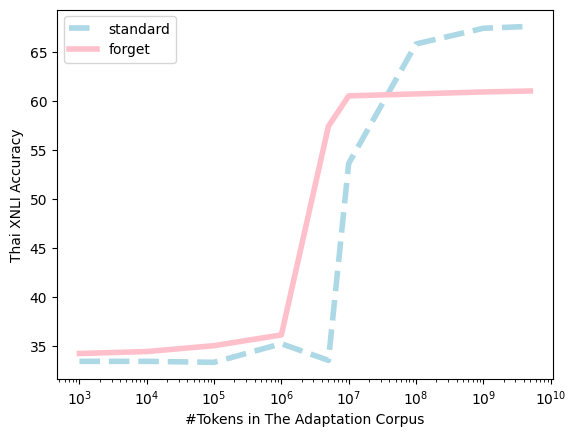

In [63]:
import seaborn as sns

# Create a figure
fig, ax = plt.subplots()

# Plot the data
sns.lineplot(x=standard['data_size'], y=standard['acc'], 
            color='lightblue', linestyle='dashed',
            label='standard',
            linewidth=4)
sns.lineplot(x=forget['data_size'], y=forget['acc'], color='pink',
             label='forget',
             linewidth=4)

# Set the x-axis label
ax.set_xlabel('#Tokens in The Adaptation Corpus')

# Set the y-axis label
ax.set_ylabel('Thai XNLI Accuracy')

# Add a legend
ax.legend()
ax.set_xscale('log')
# Show the plot
plt.show()



In [ ]:
coarse = True # !!!!!!!!!
# filter specific run
# res = res[(res['data_size'] == 0.01) | (res['data_size'] == 0.1)]
# res = res[res['model_type'] == 'forget']
# res = res[res['lang'] == 'ar']

cmd_template = """
export NLI_IRoberta="{}"
export ADAPT_IRoberta="{}"

EMB="${EXP_DIR}${ADAPT_IRoberta}"
BODY="${EXP_DIR}${NLI_IRoberta}"
SPLICE="${EXP_DIR}splice/nli/{}/"
python fb_sweep/splice_emb_body.py --emb_path $EMB --body_path $BODY --splice_path $SPLICE
"""
MAX_UPDATES = 5000
MIN_UPDATES = 0
NLI_BODY_PATH = {'standard':'cc100/nli-roberta-base/NLI.fp16.sentpred.bos0.sep2.froberta_base.adam.b2_0.98.eps1e-06.clip0.0.lr1e-05.mu122720.dr0.1.atdr0.1.wd0.01.ms32.uf1.s1.ngpu1/checkpoint_best.pt', 
                 'forget':'cc100/nli-clip0.5.adamef.k1000/NLI.fp16.sentpred.bos0.sep2.firoberta_base.adam.b2_0.98.eps1e-06.clip0.0.lr1e-05.mu122720.dr0.1.atdr0.1.wd0.01.ms32.uf1.s1.ngpu1/checkpoint_best.pt'}
model_type_list = []
data_size_list = []
num_update_list = []
alias_list = []
lang_list = []
for i,row in res.iterrows():
    lang = row['lang']
    model_dir = row['model_dir']
    model_type = row['model_type']
    data_size = row['data_size']
    files = os.listdir(row['args.save_dir'])
    # files = [f for f in files if ('_' in f) and ('best' not in f) and ('last' not in f)]
    files = [f for f in files if ('best' in f)]
    # print(files)
    for file in files:
        num_updates = file.split('_')[-1].split('.')[0]
        # if coarse == True:
        #     cond = int(num_updates) % 125000 == 0 # and int(num_updates) > 80000
        # else:
        #     cond = int(num_updates) <= MAX_UPDATES and int(num_updates) > MIN_UPDATES
        cond = True
        if cond == True:
            emb_path = model_dir + '/' + file
            body_path = NLI_BODY_PATH[model_type]
            splice_path = '{}_adapt-emb-{}{}-step{}_finetune-body-en'.format(model_type, lang, data_size, num_updates)
            # print(emb_path, splice_path)
            cmd = cmd_template.format(body_path, emb_path, splice_path, 
                                      EXP_DIR='{EXP_DIR}', 
                                      ADAPT_IRoberta='{ADAPT_IRoberta}', 
                                      NLI_IRoberta='{NLI_IRoberta}')
            print('#{}'.format(splice_path))
            print(cmd)
            num_update_list.append(num_updates)
            data_size_list.append(data_size)
            model_type_list.append(model_type)
            alias_list.append(splice_path)
            lang_list.append(lang)